## A Baseline Comparison for Image Classification between CNN, Resnet and Vision Transformers

### Getting data from kaggle

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

### get your kaggle token from kaggle.com
api_token = {"username":"*****","key":"***************"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download kaitavmehta/facial-droop-and-facial-paralysis-image

 79% 15.0M/19.0M [00:01<00:00, 24.7MB/s]
100% 19.0M/19.0M [00:01<00:00, 18.1MB/s]


In [4]:
! kaggle datasets download danish003/face-images-of-acute-stroke-and-non-acute-stroke

 95% 35.0M/36.7M [00:01<00:00, 23.9MB/s]
100% 36.7M/36.7M [00:01<00:00, 20.3MB/s]


In [6]:
import zipfile
# Extract the face images dataset
dataset_zip = "/content/face-images-of-acute-stroke-and-non-acute-stroke.zip"
dataset_dir = "/content/face-images-of-acute-stroke-and-non-acute-stroke"

with zipfile.ZipFile(dataset_zip, "r") as zip_ref:
    zip_ref.extractall("/content")

# Extract the additional stroke images dataset
additional_zip = "/content/facial-droop-and-facial-paralysis-image.zip"
additional_dir = "/content/facial-droop-and-facial-paralysis-image/Strokefaces/droopy"

with zipfile.ZipFile(additional_zip, "r") as zip_ref:
    zip_ref.extractall("/content")


In [7]:
# Set the path to the directories containing the face images
stroke_dir = '/content/main/stroke_data'#os.path.join(dataset_dir, "stroke_data")
new_stroke_dir = '/content/Strokefaces/droopy'#additional_dir
non_stroke_dir = '/content/main/noStroke_data'#os.path.join(dataset_dir, "noStroke_data")

In [8]:
import numpy as np
import os
import cv2
from tensorflow import keras
from sklearn.model_selection import train_test_split
import zipfile


# Set the image dimensions
img_width, img_height = 150, 150

# Load and preprocess the stroke images
stroke_images = []
stroke_labels = []

for filename in os.listdir(stroke_dir):
    img = cv2.imread(os.path.join(stroke_dir, filename))
    if img is not None:  # Check if the image file was successfully read
        img = cv2.resize(img, (img_width, img_height))
        stroke_images.append(img)
        stroke_labels.append(1)  # Stroke label: 1

# Load and preprocess the additional stroke images
additional_stroke_images = []
additional_stroke_labels = []

for filename in os.listdir(new_stroke_dir):
    img = cv2.imread(os.path.join(new_stroke_dir, filename))
    if img is not None:  # Check if the image file was successfully read
        img = cv2.resize(img, (img_width, img_height))
        additional_stroke_images.append(img)
        additional_stroke_labels.append(1)  # Stroke label: 1

# Load and preprocess the non-stroke images
non_stroke_images = []
non_stroke_labels = []

for filename in os.listdir(non_stroke_dir):
    img = cv2.imread(os.path.join(non_stroke_dir, filename))
    if img is not None:  # Check if the image file was successfully read
        img = cv2.resize(img, (img_width, img_height))
        non_stroke_images.append(img)
        non_stroke_labels.append(0)

In [9]:
# Combine the stroke, additional stroke, and non-stroke images and labels
images = stroke_images + additional_stroke_images + non_stroke_images
labels = stroke_labels + additional_stroke_labels + non_stroke_labels

In [10]:
len(labels)

4794

-- display images

In [11]:
import matplotlib.pyplot as plt
def display_images_from_dir(image_dir, label):
    images = []

    # Load and preprocess the images
    for filename in os.listdir(image_dir):
        img = cv2.imread(os.path.join(image_dir, filename))
        if img is not None:  # Check if the image file was successfully read
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)

    # Display a grid of 9 images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(label)
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

# Display images from stroke directory
#display_images_from_dir(stroke_dir, 'Stroke Images')

# Display images from additional stroke directory
#display_images_from_dir(new_stroke_dir, 'Additional Stroke Images')

# Display images from non-stroke directory
#display_images_from_dir(non_stroke_dir, 'Non-Stroke Images')


In [12]:
# Convert the images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

### CNN Model

In [13]:

model_cnn = keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
keras.layers.MaxPooling2D(2, 2),
# The second convolution
keras.layers.Conv2D(32, (3,3), activation='relu'),
keras.layers.MaxPooling2D(2,2),
# The third convolution
keras.layers.Conv2D(64, (3,3), activation='relu'),
keras.layers.MaxPooling2D(2,2),
# The fourth convolution
keras.layers.Conv2D(64, (3,3), activation='relu'),
keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
keras.layers.Conv2D(64, (3,3), activation='relu'),
keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
keras.layers.Flatten(),
# 512 neuron hidden layer
keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
keras.layers.Dense(1, activation='sigmoid')])
# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn=model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test)
print(f"Test loss model2: {test_loss_cnn}")
print(f"Test accuracy model2: {test_acc_cnn}")

Epoch 1/10
120/120 [==============================] - 17s 29ms/step - loss: 0.6284 - accuracy: 0.6352 - val_loss: 0.5877 - val_accuracy: 0.7331
Epoch 2/10
120/120 [==============================] - 2s 18ms/step - loss: 0.5796 - accuracy: 0.7033 - val_loss: 0.5068 - val_accuracy: 0.7675
Epoch 3/10
120/120 [==============================] - 2s 18ms/step - loss: 0.4709 - accuracy: 0.7810 - val_loss: 0.4793 - val_accuracy: 0.7758
Epoch 4/10
120/120 [==============================] - 2s 17ms/step - loss: 0.4140 - accuracy: 0.8055 - val_loss: 0.4272 - val_accuracy: 0.8060
Epoch 5/10
120/120 [==============================] - 2s 19ms/step - loss: 0.3460 - accuracy: 0.8456 - val_loss: 0.3940 - val_accuracy: 0.8342
Epoch 6/10
120/120 [==============================] - 2s 18ms/step - loss: 0.2805 - accuracy: 0.8806 - val_loss: 0.4034 - val_accuracy: 0.8311
Epoch 7/10
120/120 [==============================] - 2s 17ms/step - loss: 0.2614 - accuracy: 0.8858 - val_loss: 0.3513 - val_accuracy: 0.840

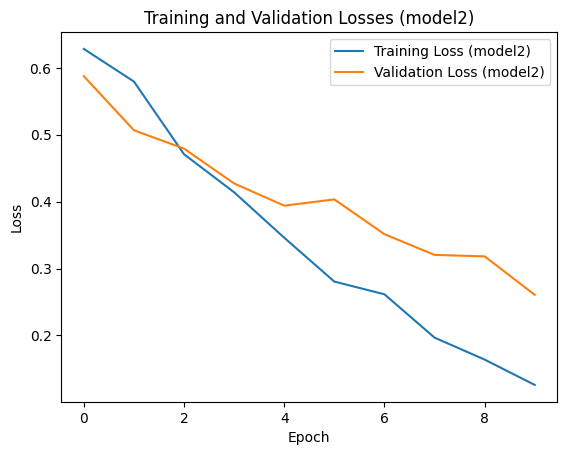

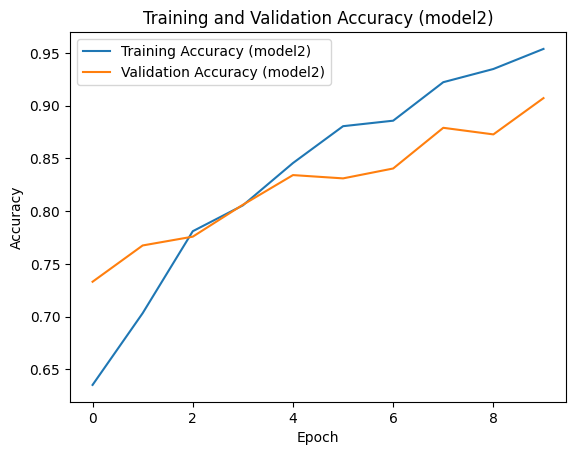

In [14]:
# Plot the training and validation losses for model2
plt.plot(history_cnn.history['loss'], label='Training Loss (model2)')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss (model2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses (model2)')
plt.show()

# Plot the training and validation accuracy for model2
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy (model2)')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy (model2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (model2)')
plt.show()

In [15]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

### Resnet

In [16]:
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.models import Model

# Create the ResNet model (ResNet50)
base_model = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))

# Add a few layers on top of the base ResNet model for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base ResNet model and the added layers
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = model_resnet.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test, y_test)
print(f"Test loss: {test_loss_resnet}")
print(f"Test accuracy: {test_acc_resnet}")

Epoch 1/10
120/120 [==============================] - 74s 253ms/step - loss: 5.0714 - accuracy: 0.5077 - val_loss: 0.6936 - val_accuracy: 0.5276
Epoch 2/10
120/120 [==============================] - 24s 203ms/step - loss: 0.7347 - accuracy: 0.5750 - val_loss: 0.6960 - val_accuracy: 0.4724
Epoch 3/10
120/120 [==============================] - 25s 209ms/step - loss: 0.5774 - accuracy: 0.7189 - val_loss: 0.8022 - val_accuracy: 0.6069
Epoch 4/10
120/120 [==============================] - 25s 204ms/step - loss: 0.4452 - accuracy: 0.8094 - val_loss: 0.5570 - val_accuracy: 0.7310
Epoch 5/10
120/120 [==============================] - 25s 213ms/step - loss: 0.3557 - accuracy: 0.8574 - val_loss: 0.7242 - val_accuracy: 0.7195
Epoch 6/10
120/120 [==============================] - 24s 202ms/step - loss: 0.3577 - accuracy: 0.8589 - val_loss: 0.5097 - val_accuracy: 0.8081
Epoch 7/10
120/120 [==============================] - 24s 204ms/step - loss: 0.2846 - accuracy: 0.8884 - val_loss: 0.3365 - val_ac

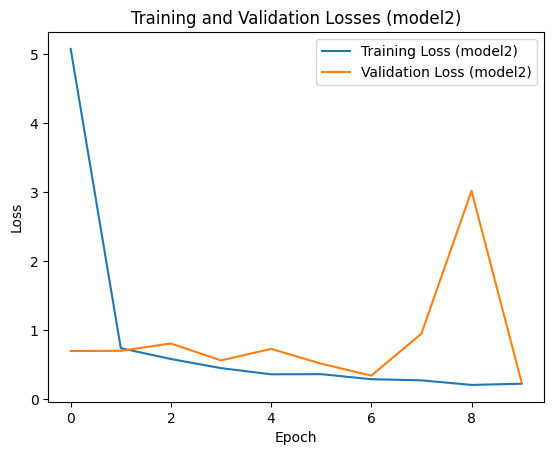

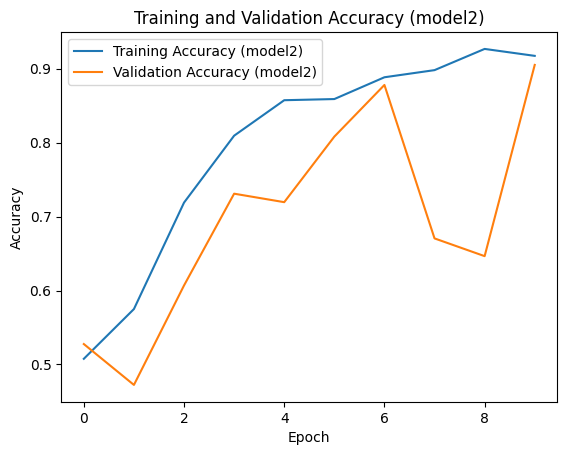

In [17]:
# Plot the training and validation losses for model2
plt.plot(history_resnet.history['loss'], label='Training Loss (model2)')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss (model2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses (model2)')
plt.show()

# Plot the training and validation accuracy for model2
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy (model2)')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy (model2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (model2)')
plt.show()

In [18]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

### Vision Transformers

- https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/11-vision-transformer.ipynb#scrollTo=9ecbd461

- https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [19]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.7 MB/s eta 0:00:00


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [21]:
num_classes = 2
input_shape = (150, 150, 3)

In [22]:
learning_rate = 0.01
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Augmentation

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

#hidden layer
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

#patch class

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
model = create_vit_classifier()
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/100
14/14 [==============================] - 34s 1s/step - loss: 136.7372 - accuracy: 0.5001 - top-5-accuracy: 1.0000 - val_loss: 1.0722 - val_accuracy: 0.5443 - val_top-5-accuracy: 1.0000
Epoch 2/100
14/14 [==============================] - 6s 423ms/step - loss: 0.9166 - accuracy: 0.4900 - top-5-accuracy: 1.0000 - val_loss: 0.6947 - val_accuracy: 0.4557 - val_top-5-accuracy: 1.0000
Epoch 3/100
14/14 [==============================] - 6s 429ms/step - loss: 0.7458 - accuracy: 0.4787 - top-5-accuracy: 1.0000 - val_loss: 0.6935 - val_accuracy: 0.4557 - val_top-5-accuracy: 1.0000
Epoch 4/100
14/14 [==============================] - 6s 405ms/step - loss: 0.7230 - accuracy: 0.4993 - top-5-accuracy: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.5443 - val_top-5-accuracy: 1.0000
Epoch 5/100
14/14 [==============================] - 6s 407ms/step - loss: 0.6922 - accuracy: 0.5210 - top-5-accuracy: 1.0000 - val_loss: 0.6915 - val_accuracy: 0.5443 - val_top-5-accuracy: 1.0000
Epoch 6/100
14/

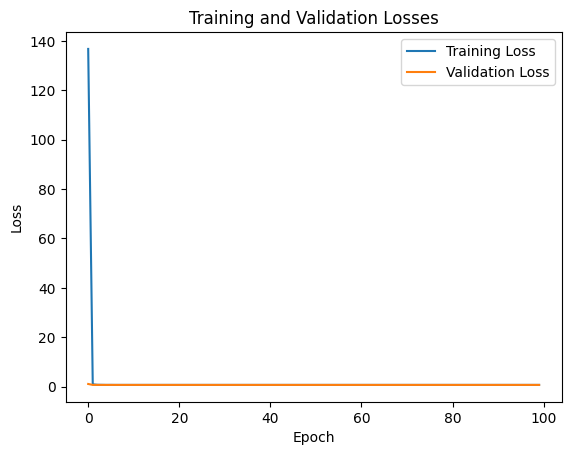

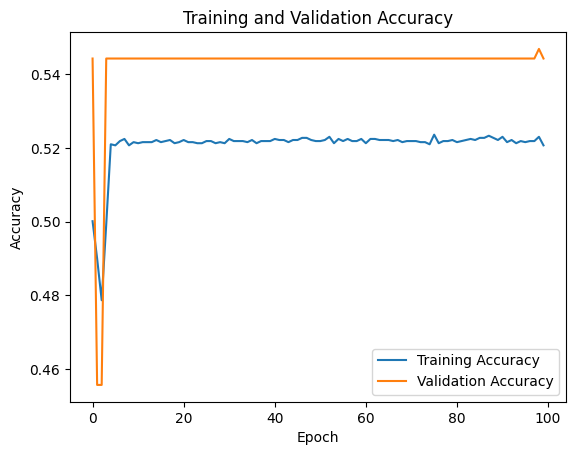

In [25]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

1/1 [==============================] - 0s 18ms/step


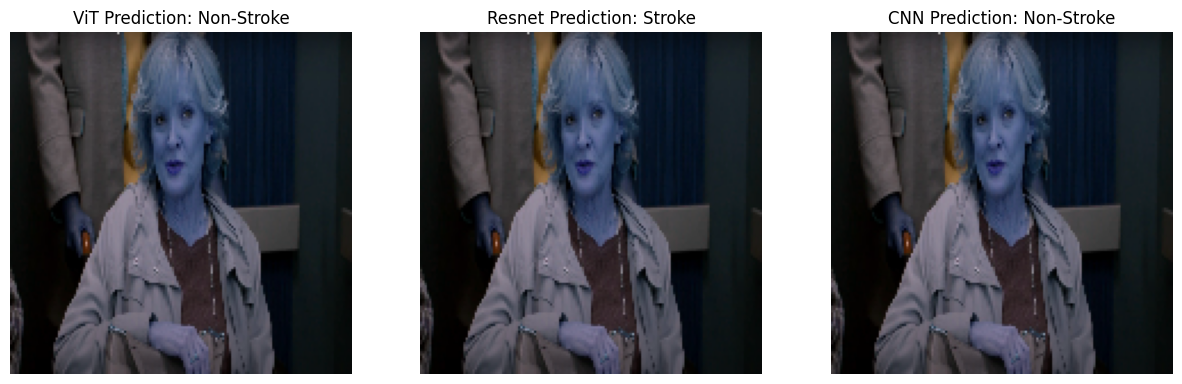

In [30]:
# Classify an image from URL
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt

def classify_image_from_url(image_url):
    # Read the image from the URL
    response = requests.get(image_url)
    img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Preprocess the image
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions using the three models
    predictions1 = model.predict(img)
    predictions2 = model_resnet.predict(img)
    predictions3 = model_cnn.predict(img)

    # Get the predicted label for each model
    label1 = "Stroke" if predictions1[0][0] > 0.5 else "Non-Stroke"
    label2 = "Stroke" if predictions2[0][0] > 0.5 else "Non-Stroke"
    label3 = "Stroke" if predictions3[0][0] > 0.5 else "Non-Stroke"

    # Display the image and the predictions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0])
    plt.title(f"ViT Prediction: {label1}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title(f"Resnet Prediction: {label2}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img[0])
    plt.title(f"CNN Prediction: {label3}")
    plt.axis('off')

    plt.show()


iu2 = 'https://www.looper.com/img/gallery/did-dottie-from-bob-hearts-abishola-really-have-a-stroke/thats-not-medical-science-but-good-acting-at-work-1632270020.jpg'
classify_image_from_url(iu2)


### Randomly Testing Models on Train Data

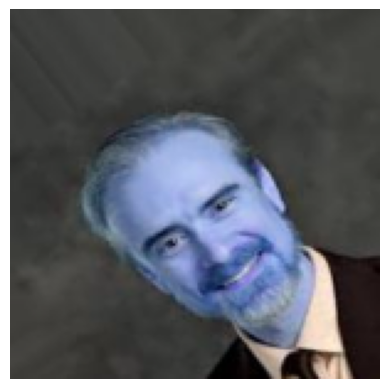

1/1 [==============================] - 0s 20ms/step
Label: 0
ViT Prediction: Not Stroke
Resnet Prediction: Not Stroke
CNN Prediction: Not Stroke


In [41]:
import random
def classify_image():
    # Randomly select an image from the dataset
    index = random.randint(0, len(images) - 1)
    image = images[index]
    label = labels[index]

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Reshape and normalize the image
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255.0

    # Make predictions using the three models
    prediction1 = model.predict(image)
    prediction2 = model_resnet.predict(image)
    prediction3 = model_cnn.predict(image)

    # Determine the class based on the predictions
    if prediction1[0][0] >= 0.5:
        prediction_label1 = "Stroke"
    else:
        prediction_label1 = "Not Stroke"

    if prediction2[0][0] >= 0.5:
        prediction_label2 = "Stroke"
    else:
        prediction_label2 = "Not Stroke"

    if prediction3[0][0] >= 0.5:
        prediction_label3 = "Stroke"
    else:
        prediction_label3 = "Not Stroke"

    # Print the label and predictions from all three models
    print("Label:", label)
    print("ViT Prediction:", prediction_label1)
    print("Resnet Prediction:", prediction_label2)
    print("CNN Prediction:", prediction_label3)
classify_image()

### Further Analysis
- Understand reasons for overfitting and absurt result in losses.
- Hyperparameter tuning.
- Add more data.
- Better pipeline for image data.